### Trading strategies
Fonte: Hilpish 2019 Python for Finance cap. 15

In [1]:
import  numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

In [2]:
#plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [3]:
raw = pd.read_csv('tr_eikon_eod_data.csv', index_col = 0, parse_dates = True)

In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2010-01-01 to 2018-06-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2138 non-null   float64
 1   MSFT.O  2138 non-null   float64
 2   INTC.O  2138 non-null   float64
 3   AMZN.O  2138 non-null   float64
 4   GS.N    2138 non-null   float64
 5   SPY     2138 non-null   float64
 6   .SPX    2138 non-null   float64
 7   .VIX    2138 non-null   float64
 8   EUR=    2216 non-null   float64
 9   XAU=    2211 non-null   float64
 10  GDX     2138 non-null   float64
 11  GLD     2138 non-null   float64
dtypes: float64(12)
memory usage: 225.1 KB


### Medie mobili semplici

In [5]:
symbol = 'AAPL.O'

In [6]:
data = (pd.DataFrame(raw[symbol])).dropna()

In [7]:
data

,AAPL.O
Date,
2010-01-04,30.572827
2010-01-05,30.625684
2010-01-06,30.138541
2010-01-07,30.082827
2010-01-08,30.282827
...,...
2018-06-25,182.170000
2018-06-26,184.430000
2018-06-27,184.160000


Creazione dei segnali

In [8]:
SMA1 = 42
SMA2 = 252


In [9]:
data['SMA1'] = data[symbol].rolling(SMA1).mean()
data['SMA2'] = data[symbol].rolling(SMA2).mean()

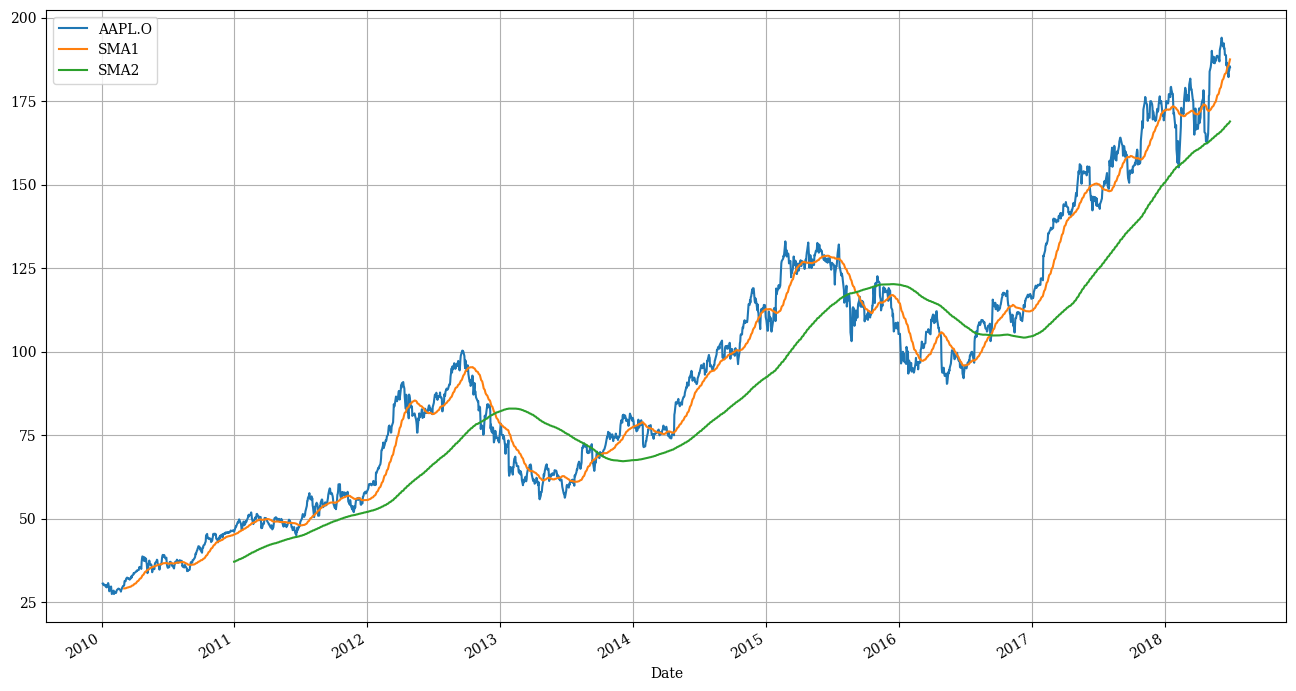

In [10]:
data.plot(figsize=(16,9))
plt.grid();

Creazione delle posizioni

In [11]:
data.dropna(inplace=True)

In [12]:
data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)

In [14]:
data.tail()

,AAPL.O,SMA1,SMA2,Position
Date,,,,
2018-06-25,182.17,185.606190,168.265556,1
2018-06-26,184.43,186.087381,168.418770,1
2018-06-27,184.16,186.607381,168.579206,1
2018-06-28,185.50,187.089286,168.736627,1
2018-06-29,185.11,187.470476,168.901032,1


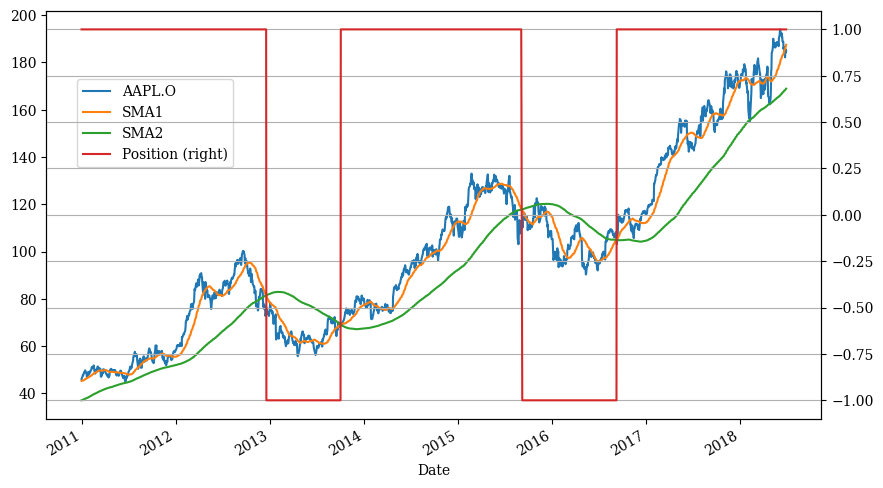

In [15]:
ax = data.plot(secondary_y = 'Position', figsize=(10,6))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))
plt.grid();

### Backtesting vettoriale

Con questo approccio la strategia è verificata operando su tutto l'insieme di dati con operazioni vettoriali.
Il metodo alternativo è il "event based backtesting" con il quale l'arrivo delle nuove informazioni dal mercato è simulato esplicitamente con un ciclo loop 

In [16]:
data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))

data['Strategy'] = data['Position'].shift(1) * data['Returns']
# rendimento della posizione di ieri per il rendimento di oggi per evitare il cosiddetto "foresigth bias"

In [20]:
data.round(3).head()

,AAPL.O,SMA1,SMA2,Position,Returns,Strategy
Date,,,,,,
2011-01-03,47.081,45.350,37.186,1,0.021,0.021
2011-01-04,47.327,45.413,37.253,1,0.005,0.005
2011-01-05,47.714,45.466,37.322,1,0.008,0.008
2011-01-06,47.676,45.523,37.392,1,-0.001,-0.001
2011-01-07,48.017,45.582,37.462,1,0.007,0.007


In [21]:
data.dropna(inplace=True)

In [22]:
np.exp(data[['Returns','Strategy']].sum())

Returns     4.017148
Strategy    5.811299
dtype: float64

In [23]:
data[['Returns','Strategy']].mean() * 252

Returns     0.185803
Strategy    0.235138
dtype: float64

In [24]:
data[['Returns','Strategy']].std() * 252 ** 0.5

Returns     0.250571
Strategy    0.250407
dtype: float64

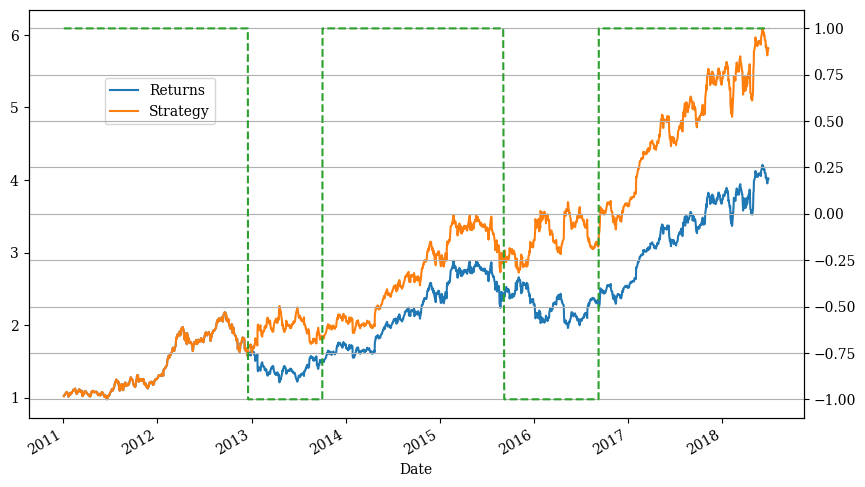

In [26]:
ax = data[['Returns', 'Strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))
data['Position'].plot(ax=ax, secondary_y='Position', style = '--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))
plt.grid();

#### Ottimizziamo i parametri
In questo esempio stiamo ottimizzando su tutto il campione.
In realtà dovremmo dividere la serie in due parti, una per l'addestramento e una per il testo dei parametri trovati

In [27]:
from itertools import product

sma1 = range(20,61,4)
sma2 = range(180,281,10)

results = pd.DataFrame()
for SMA1, SMA2 in product(sma1, sma2):
    data = pd.DataFrame(raw[symbol])
    data.dropna(inplace=True)
    data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))
    data['SMA1'] = data[symbol].rolling(SMA1).mean()
    data['SMA2'] = data[symbol].rolling(SMA2).mean()
    data.dropna(inplace=True)
    data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    data.dropna(inplace=True)
    perf = np.exp(data[['Returns','Strategy']].sum())
    new_row = pd.DataFrame({
    'SMA1': [SMA1], 
    'SMA2': [SMA2],
    'MARKET': [perf['Returns']],
    'STRATEGY': [perf['Strategy']],
    'OUT': [perf['Strategy'] - perf['Returns']]})

    results = pd.concat([results, new_row], ignore_index=True)
   

In [28]:
# Create a new DataFrame from the provided dictionary
new_row = pd.DataFrame({
    'SMA1': [SMA1], 
    'SMA2': [SMA2],
    'MARKET': [perf['Returns']],
    'STRATEGY': [perf['Strategy']],
    'OUT': [perf['Strategy'] - perf['Returns']]
})

# Concatenate the new row to the existing DataFrame 'results'
results = pd.concat([results, new_row], ignore_index=True)

In [29]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMA1      122 non-null    int64  
 1   SMA2      122 non-null    int64  
 2   MARKET    122 non-null    float64
 3   STRATEGY  122 non-null    float64
 4   OUT       122 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 4.9 KB


In [30]:
results.head(20)

,SMA1,SMA2,MARKET,STRATEGY,OUT
0,20,180,4.574979,4.326431,-0.248548
1,20,190,4.650342,5.218921,0.568579
2,20,200,4.074753,5.300207,1.225454
3,20,210,4.259883,5.219410,0.959527
4,20,220,4.220272,5.259889,1.039616
5,20,230,4.164459,5.991632,1.827173
6,20,240,4.045619,5.730486,1.684867
7,20,250,3.983434,4.718843,0.735409
8,20,260,3.762184,4.049062,0.286879
9,20,270,3.775447,3.489310,-0.286137


In [31]:
results.sort_values('OUT',ascending=False).head(10)

,SMA1,SMA2,MARKET,STRATEGY,OUT
56,40,190,4.650342,7.175173,2.524831
39,32,240,4.045619,6.558690,2.513071
59,40,220,4.220272,6.544266,2.323994
46,36,200,4.074753,6.389627,2.314874
55,40,180,4.574979,6.857989,2.283010
70,44,220,4.220272,6.469843,2.249571
101,56,200,4.074753,6.319524,2.244772
34,32,190,4.650342,6.787153,2.136811
45,36,190,4.650342,6.733936,2.083594
91,52,210,4.259883,6.335486,2.075602


#### Random walk

Se i prezzi delle azioni seguono un processo "random walk" la miglior previsione del prezzo di domani è il prezzo di oggi.
L'ipotesi di random walk è coerente con l'ipotesi di efficienza dei mercati finanziari, secondo la quale in ogni momento i prezzi riflettono tutta l'informazione disponibile.

    "Un mercato è efficiente rispetto a un insieme di informazioni S se non è possibile realizzare un profitto basandosi su questo set di informazioni" (Jensen, 1978)

Verifichiamo se è vero che solo il prezzo di ieri aiuta a prevede il prezzo di oggi

In [29]:

symbol = '.SPX'
data = pd.DataFrame(raw[symbol])

Creiamo le colonne con i valori ritardati fino a -5

In [30]:
lags = 5
cols=[]
for lag in range(1, lags+1):
    col = 'lag_{}'.format(lag)
    data[col] = data[symbol].shift(lag)
    cols.append(col)

In [31]:
data.head(10)

,.SPX,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,1132.99,NaN,NaN,NaN,NaN,NaN
2010-01-05,1136.52,1132.99,NaN,NaN,NaN,NaN
2010-01-06,1137.14,1136.52,1132.99,NaN,NaN,NaN
2010-01-07,1141.69,1137.14,1136.52,1132.99,NaN,NaN
2010-01-08,1144.98,1141.69,1137.14,1136.52,1132.99,NaN
2010-01-11,1146.98,1144.98,1141.69,1137.14,1136.52,1132.99
2010-01-12,1136.22,1146.98,1144.98,1141.69,1137.14,1136.52
2010-01-13,1145.68,1136.22,1146.98,1144.98,1141.69,1137.14


In [32]:
data.dropna(inplace=True)

Facciamo la regressione del SP 500 sui suoi valori ritardati da 1 a 5

In [33]:
reg = np.linalg.lstsq(data[cols], data[symbol], rcond=1)[0]

rcond: float, optional
Cut-off ratio for small singular values of a. For the purposes of rank determination, singular values are treated as zero if they are smaller than rcond times the largest singular value of a.

In [34]:
reg.round(3)

array([0.966, 0.005, 0.025, 0.   , 0.003])

Il coefficiente del valore -1 è prossimo a 1, gli altri sono vicini a 0

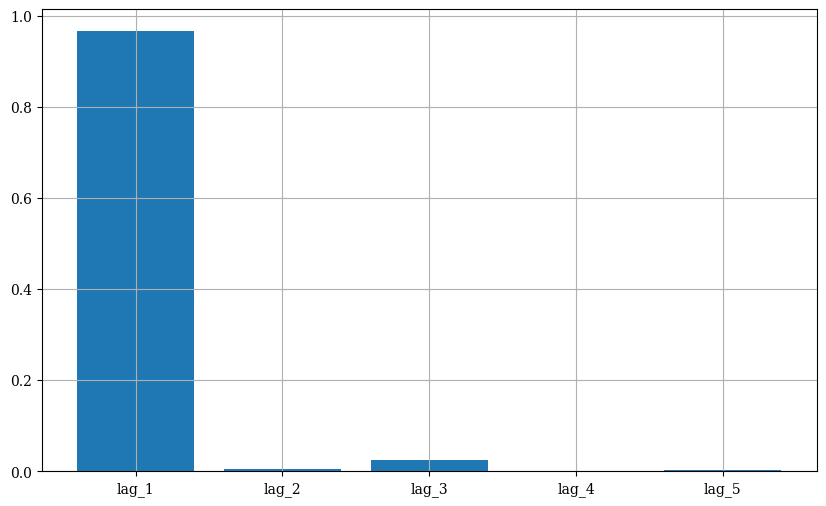

In [39]:
plt.figure(figsize=(10, 6))
plt.bar(cols, reg)
plt.grid();
# plt.savefig('../../images/ch15/strat_plot_04.png');

In [40]:
data['Prediction'] = np.dot(data[cols], reg)

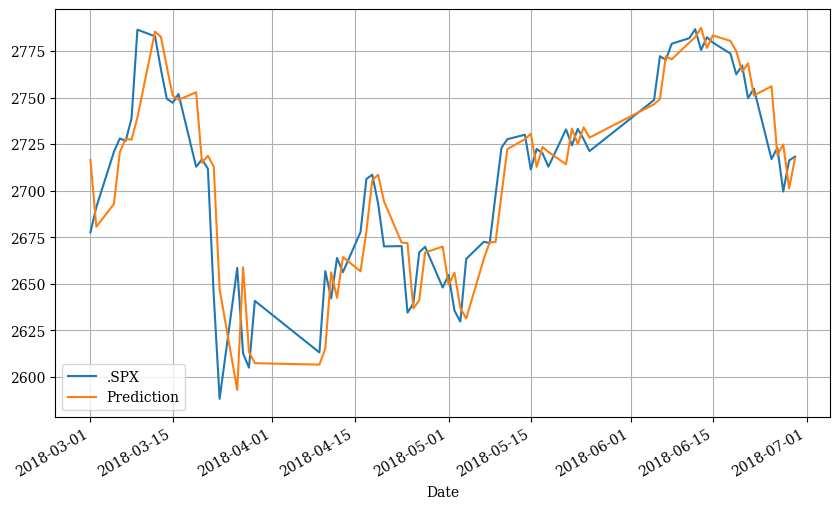

In [41]:
data[[symbol, 'Prediction']].iloc[-75:].plot(figsize=(10, 6))
plt.grid();


## Regressione lineare

Proviamo a prevedere il rendimento logaritmico del cambio euro/dollaro o la sua variazione positiva o negativa utilizzando due variabili indipendenti (features), il rendimento del giorno prima (lag_1) e quello di due giorni prima (lag_2).

### I dati

In [42]:
raw.columns

Index(['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'SPY', '.SPX', '.VIX',
       'EUR=', 'XAU=', 'GDX', 'GLD'],
      dtype='object')

In [43]:
symbol = 'EUR='

In [44]:
data = pd.DataFrame(raw[symbol])

In [45]:
data['returns'] = np.log(data / data.shift(1))

In [46]:
data.dropna(inplace=True)

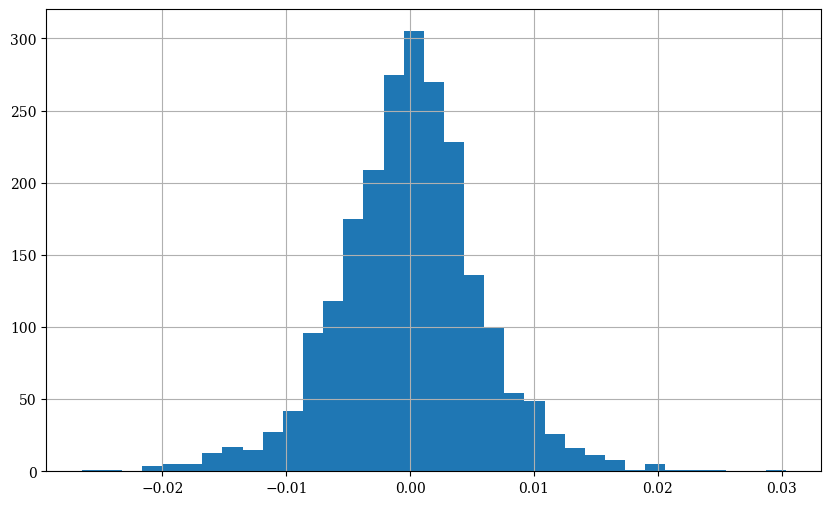

In [47]:
data['returns'].hist(bins=35, figsize=(10, 6));

In [48]:
data['direction'] = np.sign(data['returns']).astype(int)

In [49]:
data.head()

,EUR=,returns,direction
Date,,,
2010-01-04,1.4411,0.006125,1
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1


Creiamo le colonne con i valori ritardati

In [50]:
lags = 2

In [51]:
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)

In [52]:
create_lags(data)

In [53]:
data.head()

,EUR=,returns,direction,lag_1,lag_2
Date,,,,,
2010-01-04,1.4411,0.006125,1,NaN,NaN
2010-01-05,1.4368,-0.002988,-1,0.006125,NaN
2010-01-06,1.4412,0.003058,1,-0.002988,0.006125
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058


In [54]:
data.dropna(inplace=True)

In [55]:
data.head()

,EUR=,returns,direction,lag_1,lag_2
Date,,,,,
2010-01-06,1.4412,0.003058,1,-0.002988,0.006125
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544


In [56]:
data.corr()

,EUR=,returns,direction,lag_1,lag_2
EUR=,1.000000,0.025003,0.046447,0.024192,0.025548
returns,0.025003,1.000000,0.748960,-0.015655,0.007772
direction,0.046447,0.748960,1.000000,-0.033963,-0.023658
lag_1,0.024192,-0.015655,-0.033963,1.000000,-0.016088
lag_2,0.025548,0.007772,-0.023658,-0.016088,1.000000


Rappresentiamo con un grafico a dispersione i rendimenti e i loro ritardi

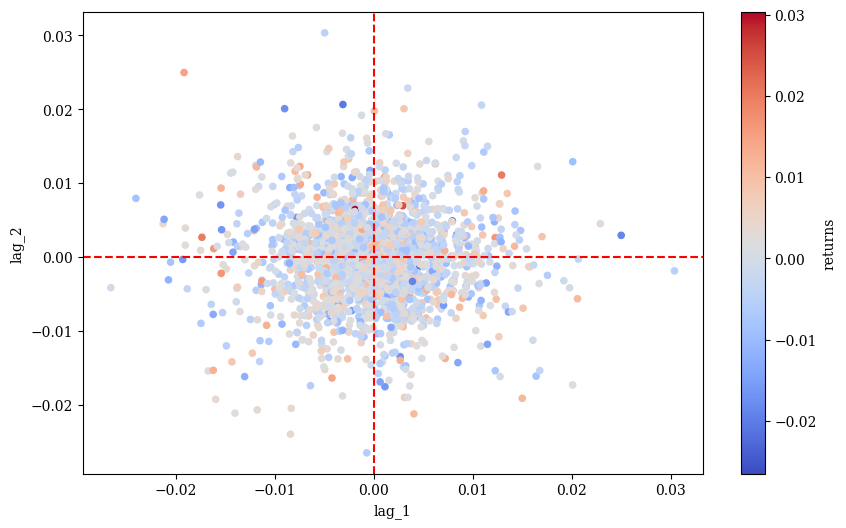

In [57]:
data.plot.scatter(x='lag_1', y='lag_2', c='returns', 
                  cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--');
# plt.savefig('strat_ml_02.png');

### Regressione

In [58]:
from sklearn.linear_model import LinearRegression

In [59]:
model = LinearRegression()

In [60]:
data['pos_ols_1'] = model.fit(data[cols],data['returns']).predict(data[cols]) #prevediamo i rendimenti

In [61]:
data['pos_ols_2'] = model.fit(data[cols], data['direction']).predict(data[cols]) #prevediamo la direzione del cambimento

In [62]:
data[['pos_ols_1','pos_ols_2']].head()

,pos_ols_1,pos_ols_2
Date,,
2010-01-06,-0.000002,-0.000663
2010-01-07,-0.000164,0.001545
2010-01-08,0.000030,0.032971
2010-01-11,-0.000245,-0.004227
2010-01-12,-0.000154,-0.061068


In [63]:
data[['pos_ols_1', 'pos_ols_2']] = np.where(
            data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)  

In [64]:
data['pos_ols_1'].value_counts()

pos_ols_1
-1    1863
 1     350
Name: count, dtype: int64

In [65]:
data['pos_ols_2'].value_counts()

pos_ols_2
 1    1310
-1     903
Name: count, dtype: int64

In [66]:
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']
data['strat_ols_2'] = data['pos_ols_2'] * data['returns']


In [67]:
data[['returns','strat_ols_1','strat_ols_2']].sum().apply(np.exp)

returns        0.813126
strat_ols_1    0.987177
strat_ols_2    1.287336
dtype: float64

Contiamo le previsioni errate e corrette

In [68]:
(data['direction'] == data['pos_ols_1']).value_counts()


False    1132
True     1081
Name: count, dtype: int64

In [69]:
(data['direction'] == data['pos_ols_2']).value_counts()


True     1145
False    1068
Name: count, dtype: int64

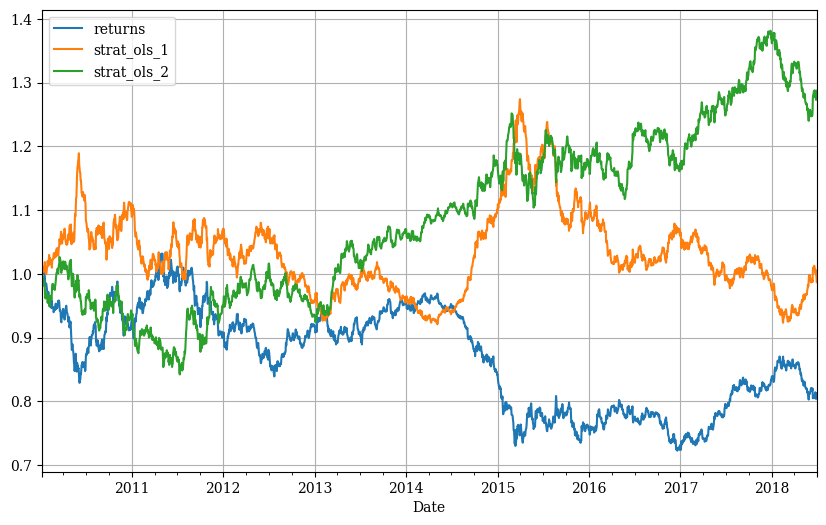

In [71]:
data[['returns','strat_ols_1','strat_ols_2']].cumsum().apply(np.exp).plot(figsize=(10,6))
plt.grid();

## Clustering

L'obiettivo è identificare due gruppi (clusters) di valori di variabili indipendenti (features) che aiutino a prevedere un movimento al rialzo o al ribasso del cambio euro/dollaro

In [72]:
from sklearn.cluster import KMeans

In [73]:
model = KMeans(n_clusters=2, random_state=0)

A problem with the k-means algorithm is that it is not optimal. That means, it is not sure to find the best solution, as the problem is not convex (for the optimisation).

One can be stuck into local minima, and hence the result of the algorithm depends of the initialization (the initial centroids). A good practice in order to find a good minimum is to rerun the algorithm several times with several initializations and keep the best result.

To define a Random_state parameter makes the results reproducible and can be useful for debugging

In [74]:
model.fit(data[cols])

C:\Users\s.bencini\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
data['pos_clus'] = model.predict(data[cols])

In [ ]:
data['pos_clus'].head()

In [ ]:
data['pos_clus'] = np.where(data['pos_clus'] == 1, -1, 1)

In [ ]:
data['pos_clus'].values

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(data[cols].iloc[:,0], data[cols].iloc[:,1], c = data['pos_clus'], cmap='coolwarm');

In [ ]:
data['strat_clus'] = data['pos_clus'] * data['returns']

In [ ]:
data[['returns','strat_clus']].sum().apply(np.exp)

In [ ]:
(data['direction'] == data['pos_clus']).value_counts()

In [ ]:
data[['returns','strat_clus']].cumsum().apply(np.exp).plot(figsize=(10,6));

### Approccio frequentista

Trasformiamo le variazioni dei valori ritardati in modo binario: 0 negativa, 1 positiva e le associamo alle variazioni positive o negative ("Directions") del cambio euro/dollaro.

Abbiamo 4 possibili combinazioni (0,0), (0,1), (1,0), (1,1) e utilizziamo la loro frequenza per prevedere la variazione del giorno successivo

In [102]:
def create_bins(data,bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins = bins)
        cols_bin.append(col_bin)


In [103]:
create_bins(data)

In [104]:
data[cols_bin + ['direction']].head()

,lag_1_bin,lag_2_bin,direction
Date,,,
2010-01-06,0,1,1
2010-01-07,1,0,-1
2010-01-08,0,1,1
2010-01-11,1,0,1
2010-01-12,1,1,-1


In [105]:
grouped = data.groupby(cols_bin + ['direction'])
grouped.size()

lag_1_bin  lag_2_bin  direction
0          0          -1           237
                       0             4
                       1           276
           1          -1           280
                       0             1
                       1           295
1          0          -1           287
                       0             1
                       1           288
           1          -1           288
                       0             5
                       1           251
dtype: int64

trasformiamo il df per avere le frequenze in colonne

In [106]:
res = grouped['direction'].size().unstack(fill_value=0)

funzione che mette in evidenza le combinanzioni di variabili con maggiore frequenza

In [107]:
def highlight_max(s):
    is_max = s == s.max
    return['backgroud-color: yellow' if v else '' for v in is_max]

In [108]:
res.style.apply(highlight_max, axis=1)

creiamo la strategia

In [109]:
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) == 2, -1, 1)

In [110]:
(data['direction'] == data['pos_freq']).value_counts()

True     1147
False    1066
dtype: int64

In [111]:
data['strat_freq'] = data['pos_freq'] * data['returns']

In [112]:
data[['returns', 'strat_freq']].sum().apply(np.exp)

returns       0.813126
strat_freq    1.016673
dtype: float64

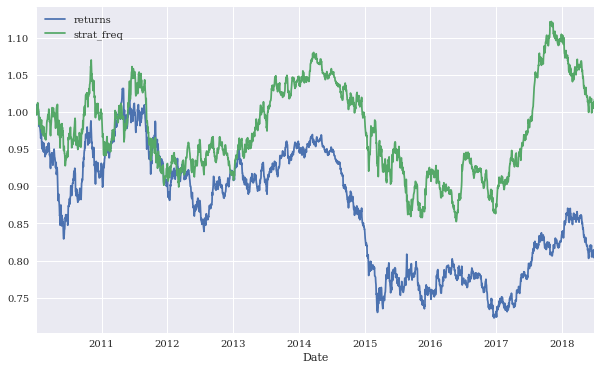

In [113]:
data[['returns','strat_freq']].cumsum().apply(np.exp).plot(figsize=(10,6));

## Classificazione

#### Due features binarie - Confronto fra tre modelli:

- Regressione logistica;
- Gaussian Naive Bayes;
- Support Vector Machine

In [114]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [115]:
C = 1

Cfloat, default=1.0
Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [116]:
models = {
    'log_reg': linear_model.LogisticRegression(C=C),
    'gauss_nb': GaussianNB(),
    'svm': SVC(C=C)
}

In [117]:
def fit_models(data):  
    mfit = {model: models[model].fit(data[cols_bin], data['direction'])
            for model in models.keys()} 

In [118]:
fit_models(data)

In [119]:
def derive_positions(data):  
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

In [120]:
derive_positions(data)

In [121]:
def evaluate_strats(data):  
    global sel
    sel = []
    for model in models.keys():
        col = 'strat_' + model 
        data[col] = data['pos_' + model] * data['returns']
        sel.append(col)
    sel.insert(0, 'returns')

In [122]:
evaluate_strats(data)

In [123]:
sel.insert(1, 'strat_freq')

In [124]:
data[sel].sum().apply(np.exp)

returns           0.813126
strat_freq        1.016673
strat_log_reg     1.385460
strat_gauss_nb    1.385460
strat_svm         1.016673
dtype: float64

Strategia frequentista e SVM, da un lato, e regressione logistica e naive Bayes, dall'altro, danno gli stessi risultati e perciò i grafici sono sovrapposti

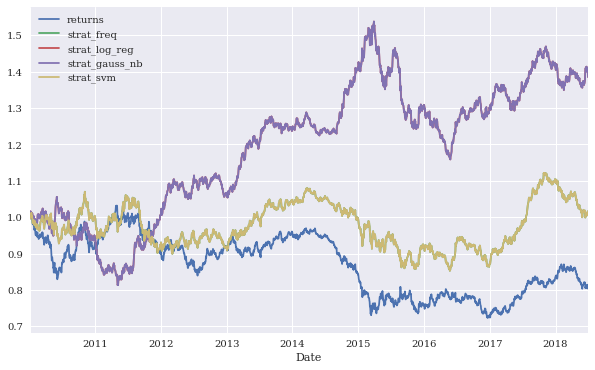

In [131]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10,6));

#### 5 features binarie - Confronto fra tre modelli:

- Regressione logistica;
- Gaussian Naive Bayes;
- Support Vector Machine

In [125]:
data = pd.DataFrame(raw[symbol])

In [126]:
data['returns'] = np.log(data / data.shift(1))

In [127]:
data['direction'] = np.sign(data['returns'])

In [128]:
lags = 5
create_lags(data)
data.dropna(inplace = True)

In [129]:
create_bins(data)

In [130]:
cols_bin

['lag_1_bin', 'lag_2_bin', 'lag_3_bin', 'lag_4_bin', 'lag_5_bin']

In [131]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-11,1,0,1,0,1
2010-01-12,1,1,0,1,0
2010-01-13,0,1,1,0,1
2010-01-14,1,0,1,1,0
2010-01-15,0,1,0,1,1


In [132]:
data.dropna(inplace=True)

In [133]:
fit_models(data)

In [134]:
derive_positions(data)

In [135]:
evaluate_strats(data)

In [136]:
data[sel].sum().apply(np.exp)

returns           0.810644
strat_log_reg     1.191997
strat_gauss_nb    1.191997
strat_svm         2.364393
dtype: float64

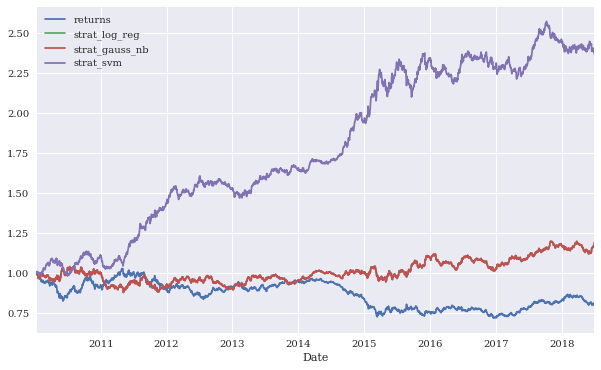

In [137]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10,6));

#### 5 features digitizzate - Più valori possibili
#### Confronto fra modelli:

- Regressione logistica;
- Gaussian Naive Bayes;
- Support Vector Machine

In [145]:
mu = data['returns'].mean()
v = data['returns'].std()

In [146]:
bins = [mu - v, mu, mu + v]
bins

[-0.005924269398870448, -9.498932088272987e-05, 0.005734290757104988]

In [147]:
create_bins(data, bins)

In [148]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-11,3,0,2,1,3
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-15,1,2,1,3,3


In [149]:
fit_models(data)

In [150]:
derive_positions(data)

In [151]:
evaluate_strats(data)

In [152]:
data[sel].sum().apply(np.exp)

returns           0.810644
strat_log_reg     1.520599
strat_gauss_nb    1.437281
strat_svm         5.815787
dtype: float64

### Sequential Train-Test Split

Tutte le analisi fatte fino ad ora erano " in sample". Nelle successive dividiamo il db in due, una parte per la stima dei parametri ("train") e una parte per la verifica delle capacità di previsione del modello su dati nuovi ("test")

In [141]:
split = int(len(data) * 0.5)

In [142]:
train = data.iloc[:split].copy()

In [143]:
fit_models(train)

In [144]:
test = data.iloc[split:].copy()

In [145]:
derive_positions(test)

In [146]:
evaluate_strats(test)

In [149]:
test[sel].sum().apply(np.exp)

returns           0.852649
strat_log_reg     1.176125
strat_gauss_nb    1.034932
strat_svm         0.738926
dtype: float64

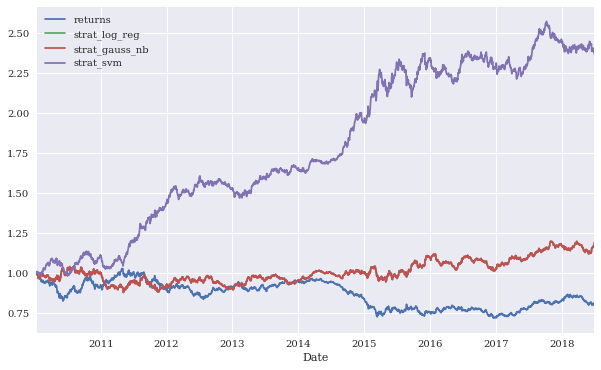

In [150]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10,6));

#### Randomized Train-Test Split

Come sopra, ma con train e test creati in modo casuale

In [151]:
from sklearn.model_selection import train_test_split

In [152]:
train, test = train_test_split(data, test_size = 0.5,
                              shuffle = True, random_state = 100)

In [153]:
train = train.copy().sort_index()

In [154]:
train[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-11,1,0,1,0,1
2010-01-12,1,1,0,1,0
2010-01-13,0,1,1,0,1
2010-01-14,1,0,1,1,0
2010-01-18,0,0,1,0,1


In [155]:
test = test.copy().sort_index()

In [156]:
fit_models(train)

In [157]:
derive_positions(test)

In [158]:
evaluate_strats(test)

In [159]:
test[sel].sum().apply(np.exp)

returns           0.736500
strat_log_reg     0.910301
strat_gauss_nb    0.958681
strat_svm         1.220376
dtype: float64

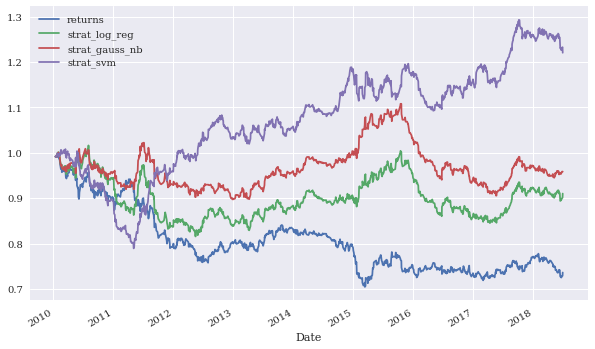

In [160]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10,6));

### Deep Neural Network
Multi Layer Perceptron

In [171]:
from sklearn.neural_network import MLPClassifier

In [173]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=2 * [250], random_state=1, max_iter = 2000)

Alpha is a parameter for regularization term, aka penalty term, that combats overfitting by constraining the size of the weights. Increasing alpha may fix high variance (a sign of overfitting) by encouraging smaller weights, resulting in a decision boundary plot that appears with lesser curvatures. Similarly, decreasing alpha may fix high bias (a sign of underfitting) by encouraging larger weights, potentially resulting in a more complicated decision boundary.

In [174]:
%time model.fit(data[cols_bin], data['direction'])

Wall time: 2min 33s


C:\Users\s.bencini\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[250, 250], max_iter=2000,
              random_state=1, solver='lbfgs')

In [175]:
data['pos_dnn_sk'] = model.predict(data[cols_bin])

In [176]:
data['strat_dnn_sk'] = data['pos_dnn_sk'] * data['returns']

In [177]:
data[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns          0.810644
strat_dnn_sk    58.116866
dtype: float64

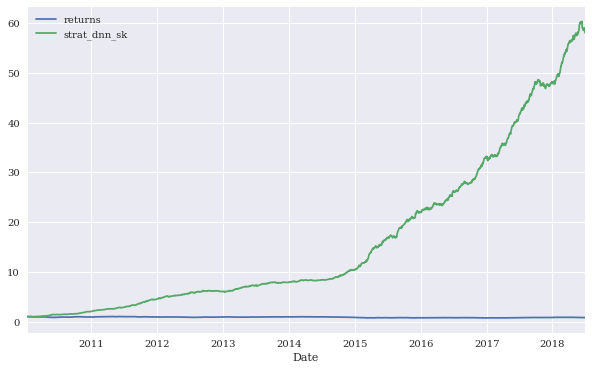

In [178]:
data[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10,6));

In [179]:
train, test = train_test_split(data, test_size=0.5, random_state=100)

In [180]:
train = train.copy().sort_index()

In [181]:
test = test.copy().sort_index()

In [182]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=2000,
                     hidden_layer_sizes=3 * [500], random_state=1)  

In [183]:
%time model.fit(train[cols_bin], train['direction'])

Wall time: 7min 41s


C:\Users\s.bencini\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[500, 500, 500], max_iter=2000,
              random_state=1, solver='lbfgs')

In [184]:
test['pos_dnn_sk'] = model.predict(test[cols_bin])

In [185]:
test['strat_dnn_sk'] = test['pos_dnn_sk'] * test['returns']

In [186]:
test[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns         0.73650
strat_dnn_sk    0.94407
dtype: float64

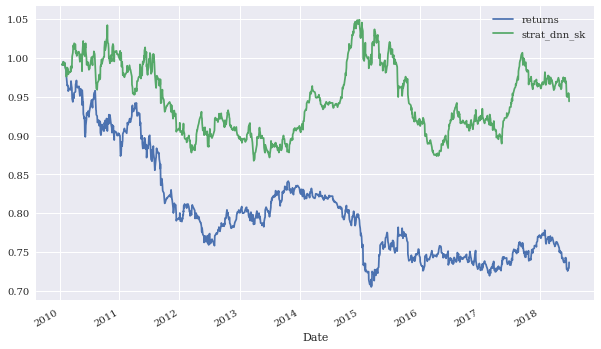

In [187]:
test[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));
plt.savefig('strat_ml_13.png');

### DNN con TensorFlow e Keras

In [180]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential

In [181]:
def create_model():
    np.random.seed(100)
    tf.random.set_seed(100)
    model = Sequential()
    model.add(Dense(16, activation='relu', input_dim=lags))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [182]:
data_ = (data - data.mean()) / data.std()
data['direction_'] = np.where(data['direction'] == 1, 1, 0)

In [183]:
model = create_model()

In [184]:
%%time
model.fit(data_[cols], data['direction_'],
          epochs=50, verbose=False)

Wall time: 1.61 s


In [185]:
model.evaluate(data_[cols], data['direction_'])

70/70 [==============================] - 0s 398us/step - loss: 0.6689 - accuracy: 0.5891


[0.6689161062240601, 0.5891402959823608]

In [186]:
pred = np.where(model.predict(data_[cols]) > 0.5, 1, 0) 
pred[:10].flatten()

array([1, 0, 0, 0, 1, 0, 0, 1, 1, 1])

In [187]:
data['pos_dnn_ke'] = np.where(pred > 0, 1, -1)  

In [188]:
data['strat_dnn_ke'] = data['pos_dnn_ke'] * data['returns']

In [189]:
data[['returns', 'strat_dnn_ke']].sum().apply(np.exp)

returns         0.810644
strat_dnn_ke    5.977176
dtype: float64

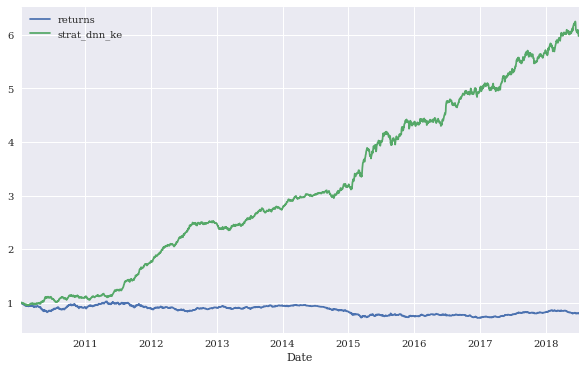

In [191]:
data[['returns', 'strat_dnn_ke']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));


In [192]:
mu, std = train.mean(), train.std()

In [193]:
train_ = (train - mu) / mu.std()

In [194]:
model = create_model()

In [195]:
train['direction_'] = np.where(train['direction'] > 0, 1, 0)

In [196]:
%%time
model.fit(train_[cols], train['direction_'],
          epochs=50, verbose=False)

Wall time: 823 ms


In [197]:
test_ = (test - mu) / std

In [198]:
test['direction_'] = np.where(test['direction'] > 0, 1, 0)

In [199]:
model.evaluate(test_[cols], test['direction_'])

35/35 [==============================] - 0s 459us/step - loss: 0.8450 - accuracy: 0.5204


[0.8450474143028259, 0.5203620195388794]

In [200]:
pred = np.where(model.predict(test_[cols]) > 0.5, 1, 0) 
pred[:10].flatten()

array([0, 1, 1, 1, 0, 1, 0, 1, 0, 0])

In [201]:
test['pos_dnn_ke'] = np.where(pred > 0, 1, -1)

In [202]:
test['strat_dnn_ke'] = test['pos_dnn_ke'] * test['returns']

In [203]:
test[['returns', 'strat_dnn_sk', 'strat_dnn_ke']].sum().apply(np.exp)

returns         0.736500
strat_dnn_sk    1.053190
strat_dnn_ke    1.244881
dtype: float64

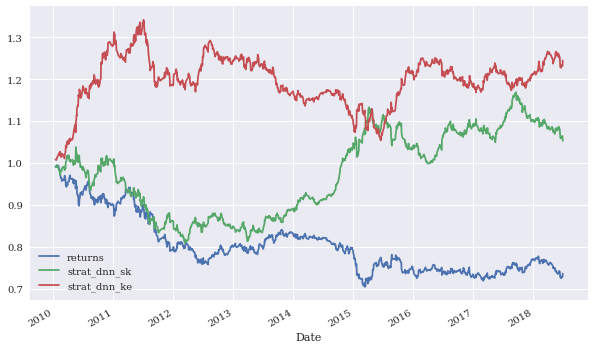

In [204]:
test[['returns', 'strat_dnn_sk', 'strat_dnn_ke']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));